# Combined Local Neighbors and Clustering-wise weights for KNNimpute


###### This script performs K-means clustering on a dataset, calculates pairwise similarity matrices, and generates a combined weight matrix for KNN imputation.

**The steps included in this notebook are:**
1. Importing Python Packages
2. Reading Datasets
3. Data Exploration and Data pre-processing: Data Cleaning & Feature Engineering (if needed)
4. Data Normalization
5. Perform K-means Clustering and Combined Weight Matrix
6. Perform artificial missingness with missing Rates
   <br>6.1 Validation of missing rate
7. Imputation process
    <br>7.1 Perform initial imputation using feature average
    <br>7.2 Perform advanced imputation using pairwise similarity matrix
8. Performance Evaluation Metrics
9. Experimental Design
    <br>9.1 Experimental datasets
    <br>9.2 Experimental run
    <br>9.3 Visualisation (bar charts + line charts)

**Benchmark datasets:**
1. iris.data (Iris)
2. Toxicity-13F.csv (Toxicity)
3. machine.data (Computer hardware)
4. data.csv (2D elastodynamic metamaterials)
5. wholesale_customer_data.csv (Whole customer)

### 1. Importing Python Packages

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error


### 2. Reading Datasets

In [2]:
# Iris dataset
df = pd.read_csv('iris.data')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### 3. Data Exploration & Data Pre-processing

Data exploration and data pre-processing are important steps in the machine learning workflow to understand and prepare the data before training models.

Some key aspects:

**Data Exploration:**

- Get basic statistics like mean, median, min, max, missing values etc. for both numerical and categorical features.

- Identify data types of features. 

- Check for outliers and anomalies.

- Visualize data distributions using histograms, box plots, scatter plots etc. 

- Understand correlations between features.

- Gain domain knowledge and insights from the data.

**Data Preprocessing:**

- Handle missing values via deletion or imputation.

- Encode categorical features to numeric.

- Normalize/standardize features to similar scales.

- Address outliers and anomalies. 

- Select relevant features and remove irrelevant ones.

- Split data into train-test sets for modeling.

- Address class imbalance if required.

The goals of these steps are to clean, transform and standardize the raw data into a proper form that can be fed into machine learning algorithms. This allows the models to learn the actual signal from the data rather than noise or artifacts.

Proper data exploration and preprocessing leads to better quality models with higher predictive performance. It is an indispensable part of the machine learning workflow.

In [3]:
# Display number of records and datatypes
dataset_info = df.info()
dataset_summary = df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
# Identify missing values
missing_values = df.isna().sum()

In [5]:
# Iris dataset
# drop the 'class' column
processed_dataset = df.drop(["class"], axis = 1)

In [6]:
processed_dataset

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


### 4. Data Normalization

Data normalization is the process of rescaling or standardizing data attributes to a common scale or range. It is an important preprocessing step in many machine learning and data mining applications.

**The main purposes of data normalization include:**

- Standardizing the range of independent variables or features of data. This helps different features contribute proportionately to the analysis.

- Avoiding biases or dominance of features with greater numerical ranges over features with smaller numerical ranges. 

- Preparing data for algorithms which expect a certain range of values such as [-1, 1] or [0, 1].

**Some common normalization techniques include:**

- Min-max normalization: Rescales the data to range between [0,1]. It is done by: (x - min(x)) / (max(x) - min(x))

- Z-score standardization: Rescales data to have mean 0 and standard deviation 1. It is done by: (x - μ) / σ where μ is mean and σ is standard deviation.

- Decimal scaling: Scales data to some decimal range like [0,1] or [-1, 1] by dividing by a power of 10.

- Mean normalization: Features are centered around the mean with mean 0. 

- Vector normalization: Vector values are normalized to length 1 by dividing by the L2 norm.

Normalization transforms data to a common scale without distorting differences in the ranges of values. This allows the normalized features to be compared and treated equally during model training and evaluation.

In [7]:
# Rescaling features into a range of [0, 1] using MinMax Scaler
minmax_scaler = MinMaxScaler()
scaled_features = minmax_scaler.fit_transform(processed_dataset)
scaled_features_df = pd.DataFrame(scaled_features, columns=processed_dataset.columns)
scaled_features_df.head()

,sepal_length,sepal_width,petal_length,petal_width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667


In [8]:
# Check the mean and standard deviation of the normalized data
print('Mean of Scaled Features:\n', scaled_features_df.mean(axis=0))
print('---------------------------------------')
print('Std Dev of Scaled Features:\n', scaled_features_df.std(axis=0))

Mean of Scaled Features:
 sepal_length    0.428704
sepal_width     0.439167
petal_length    0.467571
petal_width     0.457778
dtype: float64
---------------------------------------
Std Dev of Scaled Features:
 sepal_length    0.230018
sepal_width     0.180664
petal_length    0.299054
petal_width     0.317984
dtype: float64


### 5. Perform K-means Clustering and Combined Weight Matrix

The below code in this sectional block runs K-means multiple times with different random k-value, calculates similarity matrix each time, and averages them to get a consolidated similarity matrix independent of any single k value

Here is a detailed explanation of the code:

1. Import necessary libraries - numpy for numerical processing, sklearn for KMeans clustering, and random for sampling random numbers.

2. Define the number of iterations (num_iterations) to run the k-means clustering. This is set to 10 by default. 

3. Extract the scaled features array from a DataFrame. This is the input data for clustering.

4. Get the number of samples in the data using shape.

5. Initialize an empty average similarity matrix of shape (num_samples, num_samples) to store the average similarity over the iterations.

6. Start a for loop to iterate multiple times based on num_iterations. 

7. Select a random k between 2 and 20 using randint. Print the iteration number and k.

8. Create the KMeans model with the randomly selected k.

9. Fit the model to the scaled features to get cluster labels for each sample. 

10. Calculate the similarity matrix based on the cluster labels using outer equality comparison. This will be 1 for points in the same cluster. 

11. Update the average similarity matrix by adding the current similarity matrix.

12. After the loop ends, divide the average similarity matrix by num_iterations to take the mean over all iterations.

In [9]:
def calculate_avg_similarity_matrix(scaled_features_df, num_iterations):
    """
    Calculate the average similarity matrix using KMeans clustering.

    Parameters:
    scaled_features_df (pandas.DataFrame): DataFrame containing scaled features.
    num_iterations (int, optional): Number of iterations for the clustering process. Default is 10.

    Returns:
    avg_similarity_matrix (numpy.ndarray): Average similarity matrix.
    
    Usage Example:
    avg_similarity_matrix = calculate_avg_similarity_matrix(scaled_features_df, num_iterations)
    """
    # Import necessary libraries
    import numpy as np
    import random
    
    from sklearn.cluster import KMeans

    # Extract scaled features
    scaled_features_np = scaled_features_df.to_numpy()

    # Get Number of Samples
    num_samples = scaled_features_np.shape[0]

    # Initialize average similarity matrix
    avg_similarity_matrix = np.zeros((num_samples, num_samples))

    # Iterate multiple times
    for i in range(num_iterations):
        # select random k value
        k = random.randint(2, 20)
#         print(f"Iteration {i+1}, k = {k}")

        # Create K Means model
        kmeans_model = KMeans(n_clusters=k)
        cluster_labels = kmeans_model.fit_predict(scaled_features_np)

        # Calculate pairwise similarity matrix
        similarity_matrix = np.equal.outer(cluster_labels, cluster_labels).astype(int)

        # Update average similarity matrix
        avg_similarity_matrix += similarity_matrix

    # Take average of similarity matrices
    avg_similarity_matrix /= num_iterations

    return avg_similarity_matrix

In [10]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
 avg_similarity_matrix = calculate_avg_similarity_matrix(scaled_features_df, num_iterations = 10)

In [12]:
# Display average similarity matrix
avg_similarity_matrix

array([[1. , 0.3, 0.3, ..., 0. , 0. , 0. ],
       [0.3, 1. , 1. , ..., 0. , 0. , 0. ],
       [0.3, 1. , 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0.5, 0.6],
       [0. , 0. , 0. , ..., 0.5, 1. , 0.3],
       [0. , 0. , 0. , ..., 0.6, 0.3, 1. ]])

In [13]:
# Display average similarity matrix
pd.DataFrame(avg_similarity_matrix)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,1.0,0.3,0.3,0.3,1.0,0.5,0.8,0.9,0.3,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.3,1.0,1.0,1.0,0.3,0.3,0.5,0.4,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.3,1.0,1.0,1.0,0.3,0.3,0.5,0.4,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.3,1.0,1.0,1.0,0.3,0.3,0.5,0.4,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.3,0.3,0.3,1.0,0.5,0.8,0.9,0.3,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.3,1.0,1.0,1.0,0.3,0.5,1.0,0.3
146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3,0.3,0.5,0.3,0.3,0.3,1.0,0.5,0.3,0.5
147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.5,0.6,0.5,0.5,0.5,0.5,1.0,0.5,0.6
148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.3,1.0,1.0,1.0,0.3,0.5,1.0,0.3


### 6. Perform artificial missingness with missing Rates

The code in this section introduces missing values in a manner consistent with the Missing Completely At Random (MCAR) mechanism. 
<br>The MCAR mechanism means that the probability of a value being missing is independent of both observed and unobserved data, making it a random process.

The detailed key steps for the artificial introduction of MCAR missing values are:
1. Make a copy of the complete dataset so we don't modify the original
2. Define the missing rate (10%) and missing value (NaN)
3. Get the number of rows and columns in the dataset
4. Calculate the number of missing values to introduce based on missing rate
5. Print out the number of missing values that will be introduced
6. Randomly select the positions where missing values will be introduced without replacement
7. Loop through the selected positions
8. Calculate the row and column index for each position
9. Use iat indexer to insert NaN at the calculated row and column
10. Print out the dataset with missing values introduced

In [14]:
def artificial_missingness(dataset, missing_rate):
    """
    Introduce missing values artificially into a dataset following a MCAR (Missing Completely At Random) pattern.

    Parameters:
    dataset (pandas.DataFrame): Input dataset.
    missing_rate (float, optional): Proportion of missing values to introduce.

    Returns:
    missing_dataset (pandas.DataFrame): Dataset with introduced missing values.
    
    Usage Example:
    missing_dataset = artificial_missingness(processed_dataset, missing_rate=0.10)
    """
    # Import necessary libraries
    import numpy as np
    import pandas as pd
    
    # Make a copy of the input dataset
    missing_dataset = dataset.copy()

    # Extract the number of records and features
    num_rows, num_cols = missing_dataset.shape

    num_missing_values = int(num_rows * num_cols * missing_rate)

    # select positions randomly and Perform MCAR missingness
    positions = np.random.choice(num_rows * num_cols, num_missing_values, replace=False)

    for pos in positions:
        row_idx = pos // num_cols
        col_idx = pos % num_cols
        missing_dataset.iat[row_idx, col_idx] = np.nan

    return missing_dataset

#### 6.1 Validation of missing rate

This block section validates that the actual missing percentage introduced matches the expected missing rates within a tolerance of 1%.

The key steps in the validations process of the artificial missingness are:
1. Calculates total samples as number of rows * number of columns
2. Sum all the NaN values using 'isnull()' and 'sum()'
3. Calculate actual missing percentage
4. Print and compare expected and actual missing rates
5. Check if difference is less than 1% to accound for randomness


### 7. Imputation process

<< Process Description  Here >>

#### 7.1 Perform initial imputation using feature average 

This code section calculates the mean of each feature column, then replaces any missing values in that column with the mean. The original missing dataset is copied first to avoid modifying it directly.

The key steps are:

    1. Copy the original dataset
    2. Calculate column means
    3. Use fillna() to replace NA values with the mean

This imputes missing values with the average of each feature. You can also consider using median or mode instead of mean if they are more appropriate.

In [15]:
def feature_average_imputation(dataset):
    """
    Impute missing values in a dataset using the average value of each feature.

    Parameters:
    dataset (pandas.DataFrame): Input dataset with missing values.

    Returns:
    avg_imputed_dataset (pandas.DataFrame): Dataset with missing values imputed using feature averages.
    
    Usage Example:
    avg_imputed_dataset = feature_average_imputation(missing_dataset)
    print("\nDataFrame after feature Imputation:")
    print(avg_imputed_dataset)
    """
    # import necessary libraries
    import pandas as pd
        
    # Make a copy of the input dataset
    avg_imputed_dataset = dataset.copy()

    # Impute missing values using feature average
    for feat_col in avg_imputed_dataset.columns:
        feat_col_mean = avg_imputed_dataset[feat_col].mean()
        avg_imputed_dataset[feat_col].fillna(feat_col_mean, inplace=True)

    return avg_imputed_dataset

#### 7.2 Perform advanced imputation using pairwise similarity matrix

This section contains main steps in finding k-nearest neighbors based on similarity, handling ties if k > 1, and using the neighbors to impute the missing values.

Below details the main steps undertaken to impute the missing values using ECKNN on the datasets:
1. Made copies of the original missing dataset and average imputed dataset.
2. Converted the dataframes to numpy arrays
3. Got the number of samples and features
4. Set the diagonal of the similarity matrix to 0 to exclude self-similarity.
5. Iterated through each sample:
    - Identified missing indices for that sample.
    - For each missing column index:
        - Found k-nearest neighbors based on similarity row.
        - Sorted similarities in descending order.
        - Got max similarity.
        - Counted number of values equal to max similarity to get k.
        - Took top k max similarity indices.
        - If k > 1, computed Euclidean distances to find closest of k neighbors.
        - Used the index with minimum distance for imputation.
        - If k = 1, directly used the max similarity neighbor.
6. Imputed the missing values with the values from the selected neighbors.

        
        


In [16]:
def ecknn_imputation(missing_dataset, avg_imputed_dataset, avg_similarity_matrix, k_neighbors):
    """
    Impute missing values using Enhanced k-Nearest Neighbors (EckNN) imputation method.

    Parameters:
    missing_dataset (pandas.DataFrame): Input dataset with missing values.
    avg_imputed_dataset (pandas.DataFrame): Dataset with missing values imputed using feature averages.
    avg_similarity_matrix (numpy.ndarray): Average similarity matrix.
    k_neighbors (int, optional): Number of nearest neighbors to consider. Default is 3.

    Returns:
    ecknn_imputed_dataset (numpy.ndarray): Dataset with missing values imputed using EckNN method.
    
    Usage Example:
    ecknn_imputed_dataset = ecknn_imputation(missing_dataset, avg_imputed_dataset, avg_similarity_matrix, k_neighbors)
    """
    # Import necessary libraries
    import numpy as np
    from sklearn.metrics.pairwise import euclidean_distances
    
    # Make a copy of the input datasets
    ecknn_imputed_dataset = missing_dataset.copy()
    ecknn_avg_imputed_dataset = avg_imputed_dataset.copy()

    # Convert the dataframes to numpy arrays
    ecknn_imputed_dataset = ecknn_imputed_dataset.to_numpy()
    ecknn_avg_imputed_dataset = ecknn_avg_imputed_dataset.to_numpy()

    # Get Number of Samples and features
    num_samples, num_features = ecknn_imputed_dataset.shape

    # Exclude self similarity by setting the diagonal to 0
    np.fill_diagonal(avg_similarity_matrix, 0)

    for i in range(num_samples):
        missing_indices = np.where(np.isnan(ecknn_imputed_dataset[i]))[0]

        if missing_indices.size > 0:
            for col_idx in missing_indices:
                # Find the k-nearest neighbors based on the similarity matrix
                similarity_row = avg_similarity_matrix[i]
                # Sort in descending order
                sorted_indices = np.argsort(similarity_row)[::-1]
                                               
                # Take top k max value similarity indices
                k_max_indices = sorted_indices[:k_neighbors]            

                if k_neighbors > 1:
                    # Compute Euclidean distance and select best k_neighbors-value
                    distances = euclidean_distances([ecknn_avg_imputed_dataset[i]],
                                                    ecknn_avg_imputed_dataset[sorted_indices[:k_neighbors]])

                    # Take indices with minimum distance
                    nn_idx = sorted_indices[np.argsort(distances)][0:k_neighbors]

                    # use nn_idx (minimum distance) for imputation
                    ecknn_imputed_dataset[i, col_idx] = np.nanmean(ecknn_avg_imputed_dataset[nn_idx, col_idx])
                else:
                    # use k_max_indices for imputation
                    # Set k_neighbors = 1
                    ecknn_imputed_dataset[i, col_idx] = ecknn_avg_imputed_dataset[k_max_indices, col_idx]

    return ecknn_imputed_dataset

### 8. Performance Evaluation Metrics

In [17]:
def calculate_nrmse(processed_dataset, missing_dataset, ecknn_imputed_dataset):
    """
    Calculate the Normalized Root Mean Squared Error (NRMSE) between imputed and true values.

    Parameters:
    processed_dataset (pandas.DataFrame): Complete dataset without missing values.
    missing_dataset (pandas.DataFrame): Input dataset with missing values.
    ecknn_imputed_dataset (numpy.ndarray): Dataset with missing values imputed using EckNN method.

    Returns:
    nrmse (float): Normalized Root Mean Squared Error.
    
    Usage Example:
    nrmse = calculate_nrmse(processed_dataset, missing_dataset, ecknn_imputed_dataset)
    print("NRMSE:", nrmse)
    """
    # Import necessary libraries
    import numpy as np
    from sklearn.metrics import mean_squared_error
    
    # Find indices of missing values
    missing_indices = np.isnan(missing_dataset.to_numpy())

    # Calculate NRMSE between the complete data and imputed data for missing values
    true_values = processed_dataset.to_numpy()[missing_indices]
    imputed_values = ecknn_imputed_dataset[missing_indices]

    nrmse = np.sqrt(mean_squared_error(true_values, imputed_values)) / (true_values.max() - true_values.min())

    return nrmse

### 9. Experimental Design

#### 9.1 Experimental Datasets 

###### Life Sciences: 
1. iris.data 
2. Toxicity-13F.csv
###### Engineering:
3. machine.data
4. data.csv
###### Business
5. wholesale_customers_data.csv
6. dataset_Facebook.csv
###### Comparable Previous works
7. wine.data
8. winequality-white.csv

In [18]:
import pandas as pd

In [19]:
# Life Sciences Datasets
# 1. iris dataset (iris.data) and wisconsine breast cancer wdbc.data
# Toxicity dataset
data = pd.read_csv('iris.data')
data

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [20]:
processed_dataset = data.drop(["class"], axis = 1)
processed_dataset

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [21]:
# Rescaling features into a range of [0, 1] using MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
scaled_features = minmax_scaler.fit_transform(processed_dataset)
scaled_features_df = pd.DataFrame(scaled_features, columns=processed_dataset.columns)

#### 9.2 Experimental Run

In [22]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [23]:
import numpy as np
from sklearn.impute import KNNImputer

# Define the parameters 

# number of trials
num_trials = 10  # You can adjust this number as needed

# number of iterations
num_iters = 10

# k-neighbors value
k = 3

# Define the range of missing rate values to test
missing_rate_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2]  # Adjust as needed

# Initialize arrays to store average NRMSE and standard deviation results for each missing rate
# ecknn imputation
average_ecknn_nrmse_results = []
stddev_ecknn_nrmse_results = []

# Average feature imputation
average_feat_impute_nrmse_results = [] 
stddev_feat_impute_nrmse_results = []

# KNN imputation
average_knn_nrmse_results = []
stddev_knn_nrmse_results = []


# Perform the sequence of functions for each missing rate
for missing_rate in missing_rate_values:
    ecknn_nrmse_results = []
    feat_impute_nrmse_results = []
    knn_nrmse_results = []
    
    for trial in range(num_trials):
        avg_similarity_matrix = calculate_avg_similarity_matrix(scaled_features_df, num_iterations=num_iters)
        missing_dataset = artificial_missingness(processed_dataset, missing_rate=missing_rate)
        avg_imputed_dataset = feature_average_imputation(missing_dataset)
        ecknn_imputed_dataset = ecknn_imputation(missing_dataset, avg_imputed_dataset, avg_similarity_matrix, k_neighbors=k)
        
        # KNN Imputation
        knn_imputer = KNNImputer(n_neighbors=k)
        knn_imputed_dataset = knn_imputer.fit_transform(missing_dataset)
        
        # nrmse calculation
        ecknn_nrmse = calculate_nrmse(processed_dataset, missing_dataset, ecknn_imputed_dataset)
        feat_impute_nrmse = calculate_nrmse(processed_dataset, missing_dataset, avg_imputed_dataset.to_numpy())
        knn_nrmse = calculate_nrmse(processed_dataset, missing_dataset, knn_imputed_dataset)
        
        
        ecknn_nrmse_results.append(ecknn_nrmse)
        feat_impute_nrmse_results.append(feat_impute_nrmse)
        knn_nrmse_results.append(knn_nrmse)
    
    # Calculate and store the average NRMSE and standard deviation
    # ecknn
    average_ecknn_nrmse = np.mean(ecknn_nrmse_results)
    stddev_ecknn_nrmse = np.std(ecknn_nrmse_results)
    
    # feat average impute
    average_feat_impute_nrmse = np.mean(feat_impute_nrmse_results)
    stddev_feat_impute_nrmse = np.std(feat_impute_nrmse_results)
    
    # KNN impute
    average_knn_nrmse = np.mean(knn_nrmse_results)
    stddev_knn_nrmse = np.std(knn_nrmse_results)
    
    
    # ecknn
    average_ecknn_nrmse_results.append(average_ecknn_nrmse)
    stddev_ecknn_nrmse_results.append(stddev_ecknn_nrmse)
    
    # feat average impute
    average_feat_impute_nrmse_results.append(average_feat_impute_nrmse)
    stddev_feat_impute_nrmse_results.append(stddev_feat_impute_nrmse)
    
    # KNN
    average_knn_nrmse_results.append(average_knn_nrmse)
    stddev_knn_nrmse_results.append(stddev_knn_nrmse)

# Print or analyze the results for each missing rate
print(f"Number of Trials: {num_trials}")
print(f"Number of Iterations: {num_iters}")
print(f"K-neighbors: {k}")
print("-" * 30)
      
for i, missing_rate in enumerate(missing_rate_values):
    print(f"Missing Rate: {missing_rate:.1%}")
    print(f" ECKNN: Average NRMSE: {average_ecknn_nrmse_results[i]}, StdDev NRMSE: {stddev_ecknn_nrmse_results[i]}")
    print(f" Feat AVG: Average NRMSE: {average_feat_impute_nrmse_results[i]}, StdDev NRMSE: {stddev_feat_impute_nrmse_results[i]}")
    print(f" KNN: Average NRMSE: {average_knn_nrmse_results[i]}, StdDev NRMSE: {stddev_knn_nrmse_results[i]}")

Number of Trials: 10
Number of Iterations: 10
K-neighbors: 3
------------------------------
Missing Rate: 1.0%
 ECKNN: Average NRMSE: 0.03371862633193428, StdDev NRMSE: 0.009549852475678315
 Feat AVG: Average NRMSE: 0.19923352896083962, StdDev NRMSE: 0.06882973222239468
 KNN: Average NRMSE: 0.06297106115681271, StdDev NRMSE: 0.019518521518074695
Missing Rate: 2.0%
 ECKNN: Average NRMSE: 0.024791353317419117, StdDev NRMSE: 0.008693316957966362
 Feat AVG: Average NRMSE: 0.1768182501483077, StdDev NRMSE: 0.03248784681717281
 KNN: Average NRMSE: 0.05183181128317044, StdDev NRMSE: 0.009608997447929275
Missing Rate: 3.0%
 ECKNN: Average NRMSE: 0.02785390684528476, StdDev NRMSE: 0.006851238921034009
 Feat AVG: Average NRMSE: 0.13479551177961663, StdDev NRMSE: 0.019225277753062646
 KNN: Average NRMSE: 0.044713968174005594, StdDev NRMSE: 0.005387868882735243
Missing Rate: 4.0%
 ECKNN: Average NRMSE: 0.03113311296560604, StdDev NRMSE: 0.008842380663000086
 Feat AVG: Average NRMSE: 0.162219819423

#### 9.3 Visualisation

##### Bar Charts

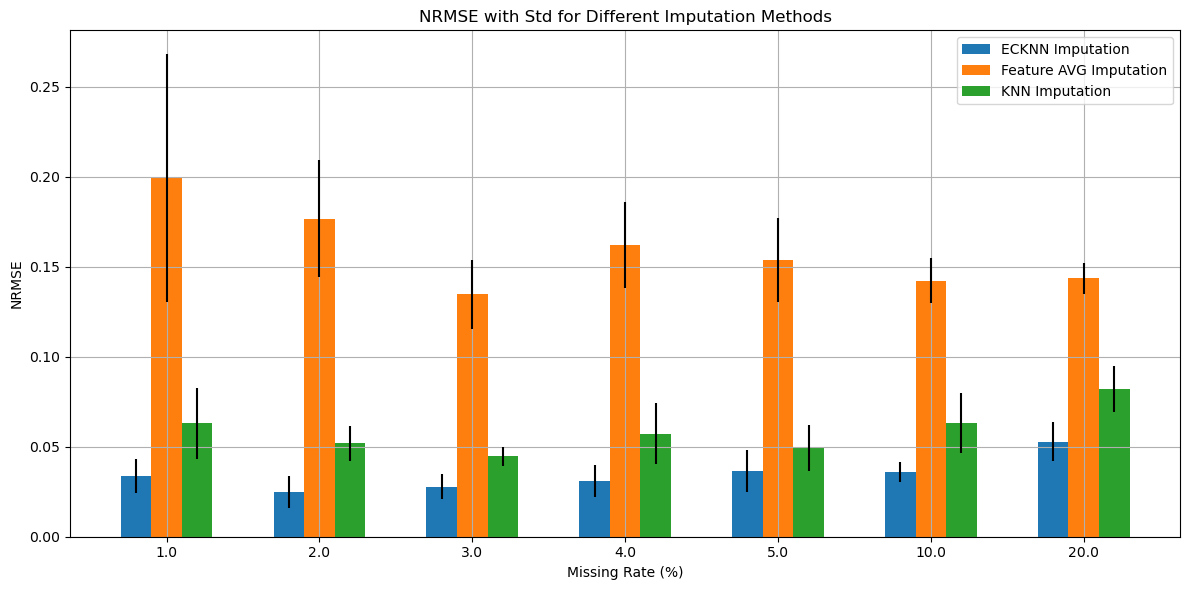

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Convert missing rates to percentages for plotting
missing_rate_percentages = [rate * 100 for rate in missing_rate_values]

# Set the width of the bars
bar_width = 0.2  # Reduce the bar width for spacing

# Calculate the positions for the bars
positions = np.arange(len(missing_rate_values))

# Create a figure and axis for the bar chart
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Create bar chart for average NRMSE with error bars for standard deviation
ax.bar(positions - bar_width, average_ecknn_nrmse_results, bar_width, label='ECKNN Imputation', yerr=stddev_ecknn_nrmse_results)
ax.bar(positions, average_feat_impute_nrmse_results, bar_width, label='Feature AVG Imputation', yerr=stddev_feat_impute_nrmse_results)
ax.bar(positions + bar_width, average_knn_nrmse_results, bar_width, label='KNN Imputation', yerr=stddev_knn_nrmse_results)

# Set x-axis labels and ticks
ax.set_xlabel('Missing Rate (%)')
ax.set_ylabel('NRMSE')
ax.set_title('NRMSE with Std for Different Imputation Methods')
ax.set_xticks(positions)
ax.set_xticklabels(missing_rate_percentages)

# Add legend and grid
ax.legend()
ax.grid(True)

# Show the bar chart
plt.tight_layout()  # Ensures labels are not cut off
plt.show()


##### Line Charts

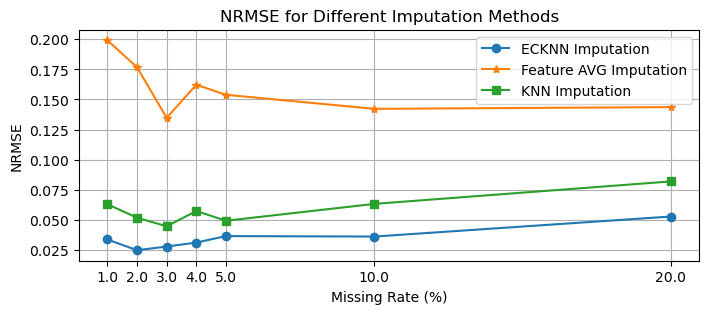

In [25]:
# Line Charts
import numpy as np
import matplotlib.pyplot as plt


# Convert missing rates into percentages for plotting
missing_rate_percentages = [rate * 100 for rate in missing_rate_values]

# Plotting the results
plt.figure(figsize=(8, 3))

# Plot average NRMSE for ecknn imputation
plt.plot(missing_rate_percentages, average_ecknn_nrmse_results, marker='o', label='ECKNN Imputation')

# Plot average NRMSE for feature average imputation
plt.plot(missing_rate_percentages, average_feat_impute_nrmse_results, marker='*', label='Feature AVG Imputation')

# Plot average NRMSE for KNN imputation
plt.plot(missing_rate_percentages, average_knn_nrmse_results, marker='s', label='KNN Imputation')

# Set plot labels and title
plt.xlabel('Missing Rate (%)')
plt.ylabel('NRMSE')
plt.title('NRMSE for Different Imputation Methods')
plt.legend()
plt.grid(True)

# Set exact missing rate percentages as x-axis tick locations and labels
plt.xticks(missing_rate_percentages, missing_rate_percentages)

# Show the plot
plt.show()

#### Plot for ECKNN Model

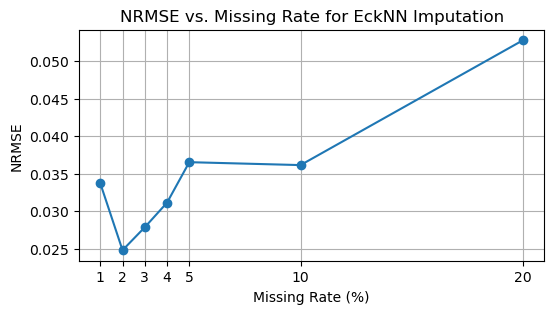

In [26]:
import matplotlib.pyplot as plt
# Plotting 1
plt.figure(figsize=(6, 3))
plt.plot(np.array(missing_rate_values) * 100, average_ecknn_nrmse_results, marker='o')
plt.title("NRMSE vs. Missing Rate for EckNN Imputation")
plt.xlabel("Missing Rate (%)")
plt.ylabel("NRMSE")
plt.grid(True)
plt.xticks(np.array(missing_rate_values) * 100)  # Adjust the x-axis ticks
plt.show()